# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import import_ipynb
import pandas as pd
import os

try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STconvolve
from StimulusnResponse import SSG
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb


In [2]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [3]:
def ParaTrans(ASparadict, mag):     # because of overfitting, I assume alpha = mag*beta
    for k in ASparadict.keys():
        globals()[k] = ASparadict[k]
    global beta, alpha, g, l, Amp 
    
    beta = epsilon*2/(1+mag)
    alpha = epsilon*2*mag/(1+mag)
    g = omegastar**2 + (alpha-beta)**2 /4
    l = ((2*omegastar*np.tan(deltastar)*(-beta+gamma)+(alpha-beta)*(beta-gamma)+2*g)/
                (g*(-alpha-beta+2*gamma-2*omegastar*np.tan(deltastar))))
    Amp = Dmp*(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)/(-beta+gamma+g*l)
    DiffParadict = {'alpha':[], 'beta':[], 'gamma':[], 'g':[], 'l':[], 'tau_y':[], 'Amp':[], 'error':[]}
    for k in DiffParadict.keys():
        DiffParadict[k] = globals()[k]
    return DiffParadict

In [4]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD2L1D_STK(Xax, Tax, sigma_dict, para_dict, ds = (1,60)):
    dx = np.mean(np.diff(Xax)) / ds[0]
    klen = min(max(sigma_dict.values())*8, Xax[-1])
    xx = np.arange(0,klen+dx,dx)
    xx = np.append(-np.flip(xx),xx[1:])
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    
    dt = np.mean(np.diff(Tax)) / ds[1]
    Tax = np.arange(0, Tax[-1]+dt, dt)
    x = Tax/para_dict['tau_y'] /para_dict['tau_y']*np.exp(-Tax/para_dict['tau_y'])*dt
    stimulus = np.zeros([len(x), int(2*(int(len(Xax)-1)/2)*ds[0]+1)])
    stimulus[:,int((int(len(Xax)-1)/2)*ds[0])] = x

    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    for i in np.arange(len(x)-1):
        s = stimulus[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i,:],KC,'same')*dx
        dyj =(-para_dict['alpha']*yts[i,:] + rs - zts[i,:])*dt
        rzs = np.convolve(zts[i,:],KC,'same')*dx
        dzj =(-para_dict['beta'] *zts[i,:] + para_dict['g']*ry2z)*dt
        ry2w = np.convolve(yts[i,:],KB,'same')*dx
        rz2w = np.convolve(zts[i,:],KH,'same')*dx
        dwj =(-para_dict['gamma']*wts[i,:] + ry2w - para_dict['l']*rz2w)*dt
        yts[i+1,:] = (yts[i,:]+dyj)
        zts[i+1,:] = (zts[i,:]+dzj)
        wts[i+1,:] = (wts[i,:]+dwj)
    yts = yts[::ds[1] ,::ds[0]]/dx/dt
    zts = zts[::ds[1] ,::ds[0]]/dx/dt
    wts = wts[::ds[1] ,::ds[0]]/dx/dt

        
    return para_dict['Amp']*wts, zts, yts

# Setting parameters from Exp. data

In [5]:
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513'
direction = 'UD'
cn = 9

## Temporal 

In [6]:
NGD2L1DASpara = np.load(exp_folder + '\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]

pd.DataFrame(para_dict).loc[cn-1]

epsilon       7.163241
gamma        34.901452
omegastar    20.631698
deltastar    -0.450280
tau_y         0.028650
Dmp           3.389743
error         1.308050
Name: 8, dtype: float64

In [7]:
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

FBFF_para_dict  = pd.DataFrame(ParaTrans(para_dict, 0.1)).loc[cn-1]
FBFF_para_dict

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


alpha      1.302408
beta      13.024075
gamma     34.901452
g        460.016331
l          0.021331
tau_y      0.028650
Amp      127.832600
error      1.308050
Name: 8, dtype: float64

## Spatial 

In [8]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)
micro_per_pixel = BS['micro_per_pixel']

RFprop  = loadmat(exp_folder+'\\Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat', squeeze_me =True)

hLA = RFprop['RF_properties'][cn-1]['X_Width'] #semi-major-axis
hSA = RFprop['RF_properties'][cn-1]['Y_Width'] #semi-minor-axis
theta = RFprop['RF_properties'][cn-1]['Angle'] #Angel between major-axis and x-axis
YC = RFprop['RF_properties'][cn-1]['Y_Coor']-BS['meaCenter_y'] #ellipse y-center to Motion center
XC = RFprop['RF_properties'][cn-1]['X_Coor']-BS['meaCenter_x'] #ellipse x-center to Motion center

In [9]:
if direction == 'RL':  #'LR' actually
    DisFC = XC *micro_per_pixel *0.001 # distance from center #mm
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(theta))**2 + (hSA*np.cos(theta))**2 ) *0.001 #radius along motion direction #mm
elif direction == 'UL_DR':
    DisFC = (XC+YC)/np.sqrt(2)
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(np.pi/4+theta))**2 + (hSA*np.cos(np.pi/4+theta))**2 ) *0.001
elif direction == 'UD':
    DisFC = YC *micro_per_pixel *0.001 
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(np.pi/2+theta))**2 + (hSA*np.cos(np.pi/2+theta))**2 ) *0.001
elif direction == 'UR_DL':
    DisFC = (-XC+YC)/np.sqrt(2)
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(np.pi*3/4+theta))**2 + (hSA*np.cos(np.pi*3/4+theta))**2 ) *0.001

In [10]:
RaMD/1.5

0.20426678569344126

In [11]:
FBFF_sigma_dict = dict()
FBFF_sigma_dict['B'] = RaMD *1.1/1.5 #mm from exp data (RF radius = 1.5*sigma)
FBFF_sigma_dict['H'] = 3*FBFF_sigma_dict['B'] # 
FBFF_sigma_dict['C'] = 0.05*FBFF_sigma_dict['B'] # has to be small enough

dx = 0.0076 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) #Half length of xais, (mm)
# hXstep =  int(1.015 /dx) #range of Checkboard, 1.5*sqrt(2)/2
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

# STK

In [12]:
Delta_output_w, zts, Delta_output_y = NGD2L1D_STK(SKxaxis, TKtaxis, FBFF_sigma_dict, FBFF_para_dict, )

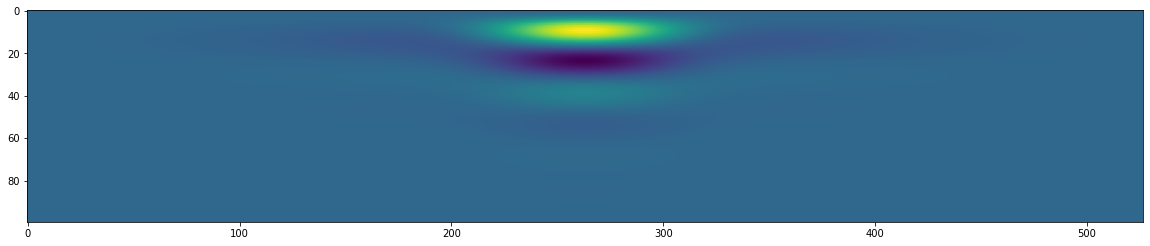

In [13]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)

In [14]:
delSTK = Delta_output_w
# delSTK2 = Delta_output_w2/dt/dx

In [15]:
iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
SeSTK = SeSTK/np.max(SeSTK)*np.max(delSTK)

# SVD

In [16]:
from numpy import linalg as la
U,sigma,VT=la.svd(delSTK)

In [17]:
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
        

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[8.49906918e-01 1.49701747e-01 3.60012188e-04 2.07284650e-05
 6.07710374e-06]


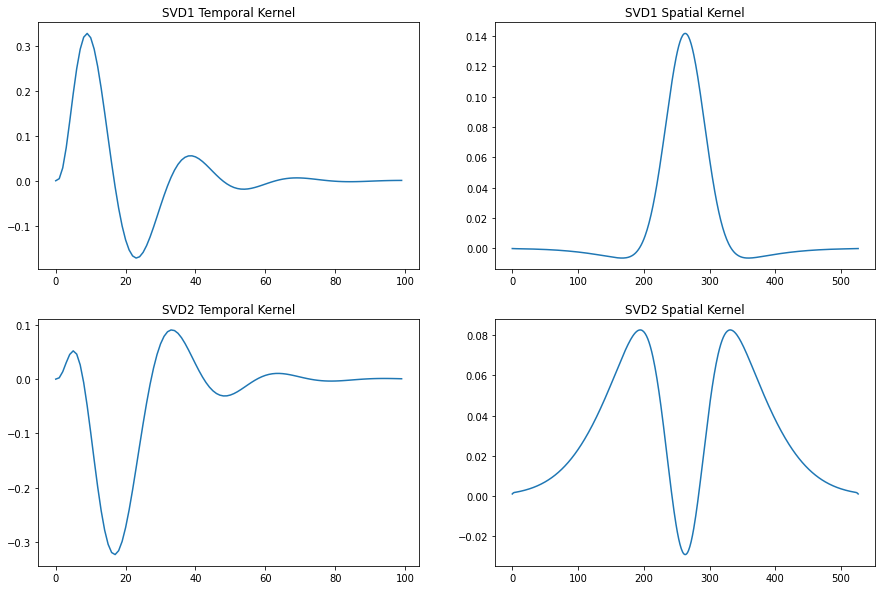

In [18]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

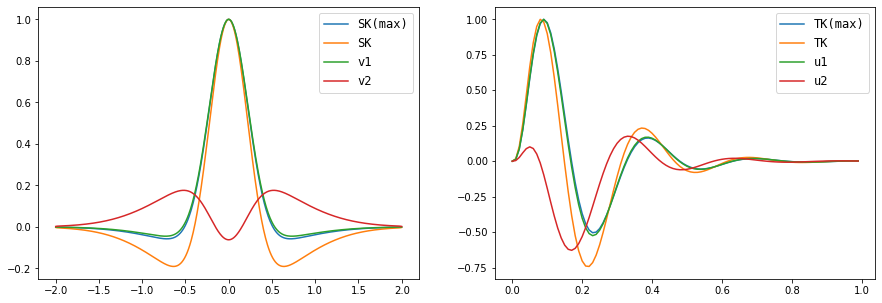

In [19]:
fig, ax = plt.subplots(1,2)
ax[0].plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), label='SK(max)')
ax[0].plot(SKxaxis, iSK/np.max(iSK), label='SK')
ax[0].plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), label='v1')
ax[0].plot(SKxaxis, VT[1,:]/np.max(VT[1,:]) *sigma[1]/sigma[0], label='v2')

ax[1].plot(TKtaxis, delSTK[:, np.where(delSTK == np.max(delSTK))[1][0]]/np.max(delSTK), label='TK(max)')
ax[1].plot(TKtaxis, iTK/np.max(iTK), label='TK')
ax[1].plot(TKtaxis, U[:,0]/np.max(U[:,0]), label='u1')
ax[1].plot(TKtaxis, U[:,1]/np.max(U[:,1]) *sigma[1]/sigma[0], label='u2')

ax[0].legend(loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[1].legend(loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15,5)

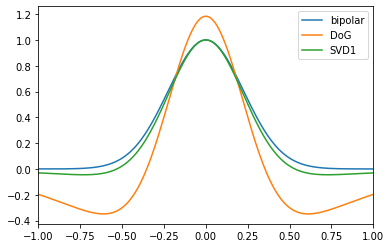

In [20]:
KC = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['C'])
KH = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['H'])
KB = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['B'])

# plt.plot(SKxaxis, KC, label = 'cone')
# plt.plot(SKxaxis, KH, label = 'horizontal')
plt.plot(SKxaxis, KB/max(KB), label = 'bipolar')
plt.plot(SKxaxis, KB-KH, label = 'DoG')
plt.plot(SKxaxis, VT[0,:]/max(VT[0,:]), label = 'SVD1')

plt.xlim([-1,1])
plt.legend()

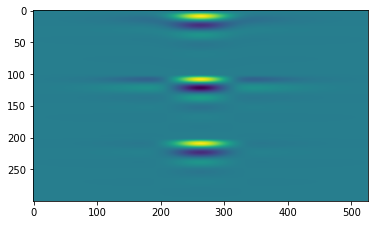

In [21]:
plt.imshow(np.vstack((delSTK,SeSTK,SVDSTK)))

# Fit SK with DoG

[0.08716565 0.22489073 0.02175228 0.67425928]
{'B': 0.2246934642627854, 'H': 0.6740803927883562, 'C': 0.01123467321313927}


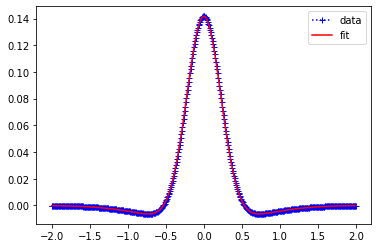

In [22]:
from scipy.optimize import curve_fit
SK = VT[0,:]

def DoG(x, a1, sigma1, a2, sigma2):
    return a1*Gaussian_filter_1d(x,sigma1)-a2*Gaussian_filter_1d(x,sigma2)

popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK), 23, 0.1*max(SK), 5*23], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)
print(FBFF_sigma_dict)
plt.plot(SKxaxis, SK, 'b+:', label='data')
plt.plot(SKxaxis,  DoG(SKxaxis, *popt), 'r-', label='fit')
plt.legend()

[0.0742009  0.20558405]
{'B': 0.2246934642627854, 'H': 0.6740803927883562, 'C': 0.01123467321313927}


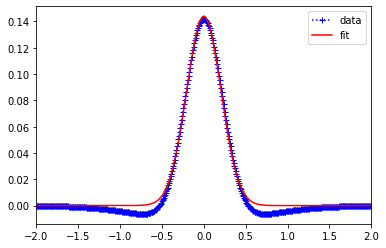

In [23]:
from scipy.optimize import curve_fit
SK = VT[0,:]

def Gaussian(x, a1, sigma1):
    return a1*Gaussian_filter_1d(x,sigma1)

popt,pcov = curve_fit(Gaussian, SKxaxis, SK, p0=[max(SK), 23], bounds = (0, np.inf))
print(popt)
print(FBFF_sigma_dict)
plt.plot(SKxaxis, SK, 'b+:', label='data')
plt.plot(SKxaxis,  Gaussian(SKxaxis, *popt), 'r-', label='fit')
plt.xlim([-2, 2])
plt.legend()

RF = Gaussian(SKxaxis, *popt)

# Steady State of Constant Moving Bar
SK of moving frame

In [24]:
def SquareWave(hw): #hw is dimensionless
    xaxis = np.arange(-hw-1, hw+2)
    SW = np.ones_like(xaxis)
    SW[[0,-1]] = 0
    return SW

def GaussianWave(s):#sigma is dimensionless
    xaxis = np.arange(-5*s, 5*s+1)
    return (np.exp(-(xaxis/s)**2/2))

In [25]:
def StadyState_ConstMoveDelta(v, Kernel, dx, dt): 
    v = v*dt/dx #dimensionless v
    if Kernel.shape[1]%2 == 0: return
    addlen = int(v*(Kernel.shape[0]-1))
    
    xaxis = np.arange(-int(Kernel.shape[1]/2)-addlen, int(Kernel.shape[1]/2)+1)*dx
    last_mb_y = np.zeros_like(xaxis)
    for k in range(Kernel.shape[0]):
        shift = int(v*k)
        last_mb_y += np.hstack((np.zeros(addlen-shift) ,Kernel[k,:], np.zeros(shift)))*dt
    return last_mb_y, xaxis

## Control: v,  Independent: hw and $\sigma$

In [43]:
v = 0.44 #mm/s #berry
delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
SeSKvp,  xaxis = StadyState_ConstMoveDelta(v, SeSTK,  dx, dt)
SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)

In [44]:
np.where(xaxis==0)

(array([320], dtype=int64),)

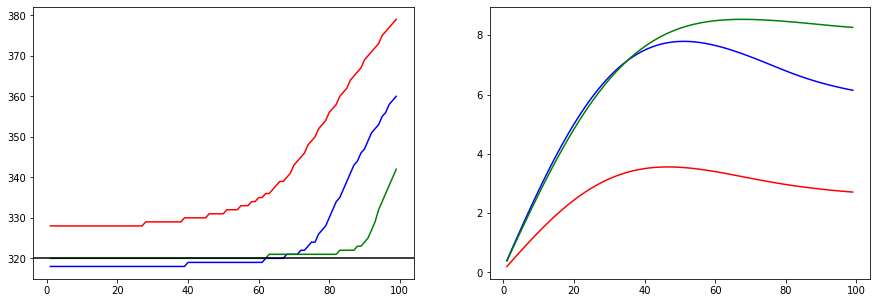

In [45]:
fig, ax = plt.subplots(1,2)
hw_list = np.arange(1,100,1)
del_hw2y = np.array([np.convolve(delSKvp, SquareWave(hw), 'same') for hw in hw_list])
se_hw2y  = np.array([np.convolve(SeSKvp , SquareWave(hw), 'same') for hw in hw_list])
svd_hw2y = np.array([np.convolve(SVDSKvp, SquareWave(hw), 'same') for hw in hw_list])


ax[0].plot(hw_list, np.argmax(del_hw2y, axis = 1), c='b')
ax[0].plot(hw_list, np.argmax(se_hw2y, axis = 1), c='r')
ax[0].plot(hw_list, np.argmax(svd_hw2y, axis = 1), c='g')
ax[0].axhline( np.where(xaxis==0), c = 'k' )
ax[1].plot(hw_list, np.max(del_hw2y, axis = 1), c='b')
ax[1].plot(hw_list, np.max(se_hw2y, axis = 1), c='r')
ax[1].plot(hw_list, np.max(svd_hw2y, axis = 1), c='g')
fig.set_size_inches(15,5)

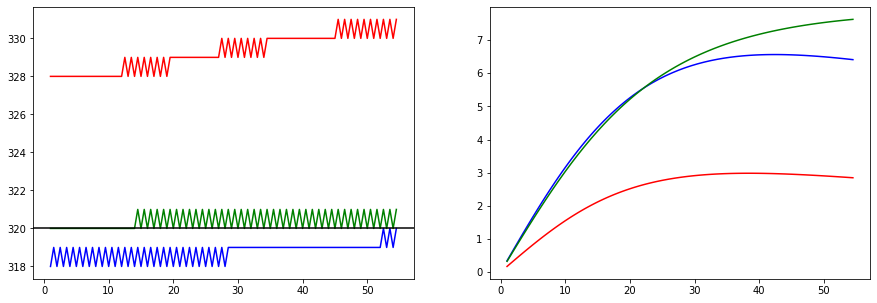

In [48]:
fig, ax = plt.subplots(1,2)
sigma_list = np.arange(1,55,0.5)

del_sigma2y = np.array([np.convolve(delSKvp, GaussianWave(sig), 'same') for sig in sigma_list])
se_sigma2y  = np.array([np.convolve(SeSKvp , GaussianWave(sig), 'same') for sig in sigma_list])
svd_sigma2y = np.array([np.convolve(SVDSKvp, GaussianWave(sig), 'same') for sig in sigma_list])


ax[0].plot(sigma_list, np.argmax(del_sigma2y, axis = 1), c='b')
ax[0].plot(sigma_list, np.argmax(se_sigma2y, axis = 1), c='r')
ax[0].plot(sigma_list, np.argmax(svd_sigma2y, axis = 1), c='g')
ax[0].axhline( np.where(xaxis==0), c = 'k' )
ax[1].plot(sigma_list, np.max(del_sigma2y, axis = 1), c='b')
ax[1].plot(sigma_list, np.max(se_sigma2y, axis = 1), c='r')
ax[1].plot(sigma_list, np.max(svd_sigma2y, axis = 1), c='g')
    
fig.set_size_inches(15,5)

## Control: hw and $\sigma$,  Independent: v

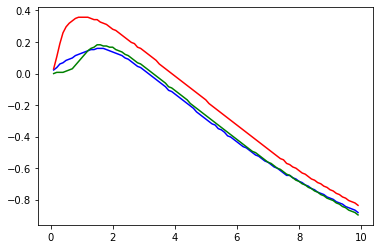

In [50]:
hw = 80
del_preceed = []
Se_preceed = []
SVD_preceed = []
v_list = np.arange(0.1,10,0.1)
for v in v_list:
    delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
    delSKvphw = np.convolve(delSKvp , SquareWave(hw), 'same')
    del_preceed.append(xaxis[np.argmax(delSKvphw)])
    
    SeSKvp, xaxis = StadyState_ConstMoveDelta(v, SeSTK, dx, dt)
    SeSKvphw = np.convolve(SeSKvp , SquareWave(hw), 'same')
    Se_preceed.append(xaxis[np.argmax(SeSKvphw)])

    
    SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)
    SVDSKvphw = np.convolve(SVDSKvp , SquareWave(hw), 'same')
    SVD_preceed.append(xaxis[np.argmax(SVDSKvphw)])
    
plt.plot(v_list, del_preceed, c='b')
plt.plot(v_list, Se_preceed, c='r')
plt.plot(v_list, SVD_preceed, c='g')

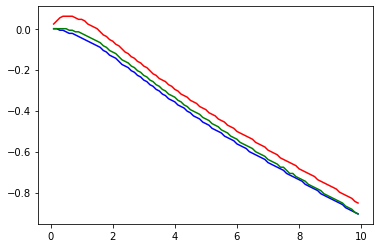

In [31]:
sigma = 6.8
del_preceed = []
Se_preceed = []
SVD_preceed = []
v_list = np.arange(0.1,10,0.1)
for v in v_list:
    delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
    delSKvpsig = np.convolve(delSKvp , GaussianWave(sigma), 'same')
    del_preceed.append(xaxis[np.argmax(delSKvpsig)])
    
    SeSKvp, xaxis = StadyState_ConstMoveDelta(v, SeSTK, dx, dt)
    SeSKvpsig = np.convolve(SeSKvp , GaussianWave(sigma), 'same')
    Se_preceed.append(xaxis[np.argmax(SeSKvpsig)])
    
    SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)
    SVDSKvpsig = np.convolve(SVDSKvp , GaussianWave(sigma), 'same')
    SVD_preceed.append(xaxis[np.argmax(SVDSKvpsig)])
    
plt.plot(v_list, del_preceed, c='b')
plt.plot(v_list, Se_preceed, c='r')
plt.plot(v_list, SVD_preceed, c='g')

## plot specific

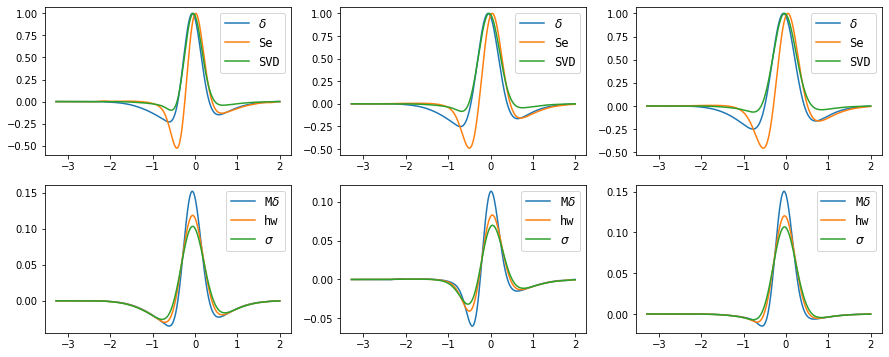

In [32]:
v = 1.3
fig, ax = plt.subplots(2,3)
hw = 30
sigma = (2*hw+1)/np.sqrt(2*np.pi)

c = 0
for STK in [delSTK, SeSTK, SVDSTK]:
    SKvp, xaxis = StadyState_ConstMoveDelta(v, STK, dx, dt)

    ax[0][0].plot(xaxis, SKvp/max(SKvp))
    ax[1][c].plot(xaxis, SKvp)

    SKvphw = np.convolve(SKvp, SquareWave(hw), 'same')
    ax[0][1].plot(xaxis, SKvphw/max(SKvphw))
    ax[1][c].plot(xaxis, SKvphw/sum(SquareWave(hw)))

    SKvpsig = np.convolve(SKvp, GaussianWave(sigma), 'same')
    ax[0][2].plot(xaxis, SKvpsig/max(SKvpsig))
    ax[1][c].plot(xaxis, SKvpsig/sum(GaussianWave(sigma)))
    c+=1
    
for axi in ax[0]:
    axi.legend((r'$\delta$', 'Se', 'SVD'),loc='best', prop={'size': 'large', 'family': 'monospace'})
for axi in ax[1]:
    axi.legend((r'M$\delta$', 'hw', r'$\sigma$'),loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15,6)

# LPOU 

In [33]:
DR = BS['mea_size']*micro_per_pixel *0.001 #mm
dDR = int(DR/dx+0.5)

Tto = 60
LPOUtaxis = np.arange(0,Tto,dt)
LPOU = SSG([1], dt, Tto, tau = 1, D = 1)[0]
rsLPOU = ((LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*(dDR-1E-6)).astype(int)

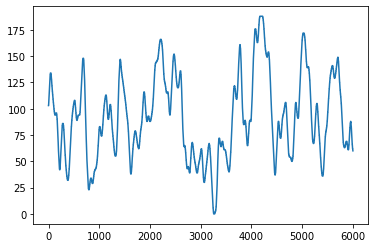

In [34]:
plt.plot(rsLPOU)

In [35]:
LPOU_bar = np.zeros([len(LPOU),dDR])
for i in range(len(LPOU)):
    LPOU_bar[i, rsLPOU[i]] = 1

In [36]:
def STconvolve(x,k,dx,dt):
    output = np.zeros([x.shape[0],k.shape[1]])
    for i in range(x.shape[0]):
        for ii in np.arange(max(i-k.shape[0]+1, 0), i+1):
            output[i,:] += np.convolve(x[ii,:],k[i-ii, :],'same')*dx*dt
    return output

STK_r = STconvolve(LPOU_bar,delSTK,dx,dt)
SeSTK_r = STconvolve(LPOU_bar,SeSTK,dx,dt)
SVDSTK_r = STconvolve(LPOU_bar,SVDSTK,dx,dt)


KeyboardInterrupt: 

In [ ]:
Inten = np.array([np.convolve(LPOU_bar[i, :], RF) for i in range(len(LPOU))])

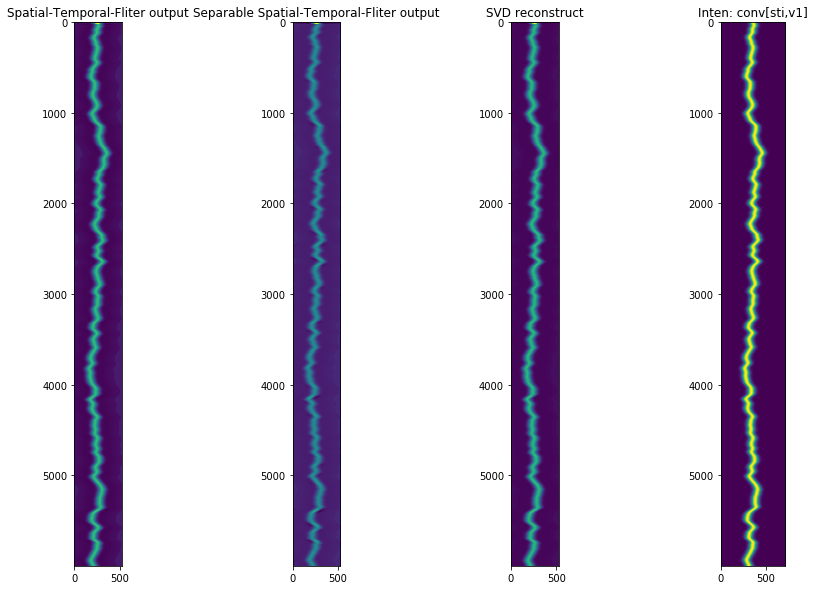

In [ ]:
fig, ax = plt.subplots(1,4) 
ax[0].imshow(STK_r)
ax[0].set_title('Spatial-Temporal-Fliter output')
ax[1].imshow(SeSTK_r)
ax[1].set_title('Separable Spatial-Temporal-Fliter output')
ax[2].imshow(SVDSTK_r)
ax[2].set_title('SVD reconstruct')
ax[3].imshow(Inten)
ax[3].set_title('Inten: conv[sti,v1]')
fig.set_size_inches(15, 10)

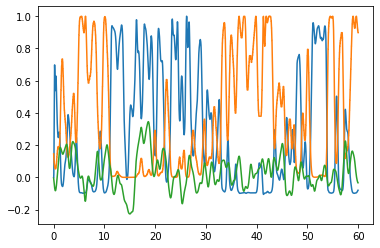

In [ ]:
CellIndex = int(np.interp(DisFC, SKxaxis, np.arange(len(SKxaxis)))+0.5)
r1 = STK_r[:, CellIndex]
I1 = Inten[:, CellIndex]
plt.plot(LPOUtaxis, r1/max(r1))
plt.plot(LPOUtaxis, I1/max(I1))
plt.plot(LPOUtaxis, LPOU/5)

In [ ]:
Xcorr = np.correlate(I1, r1, 'same')/np.correlate(np.ones_like(I1), r1, 'same')

(-1, 1)

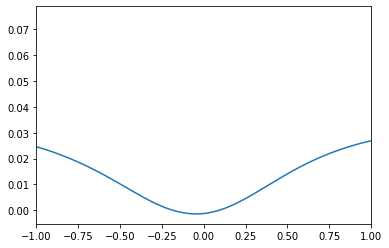

In [ ]:
plt.plot(LPOUtaxis-LPOUtaxis[int(len(LPOUtaxis)/2)],Xcorr)
plt.xlim([-1,1])